# Final Project

In [43]:
# 移除不必要的警告
import warnings
warnings.filterwarnings('ignore')

### 獲取歷史資料

In [44]:
from finlab.data import Data

data = Data()

rev = data.get("當月營收")

close = data.get_adj("收盤價")
open_ = data.get_adj("開盤價")
high = data.get_adj("最高價")
low = data.get_adj("最低價")
vol = data.get("成交股數")

PB = data.get("股價淨值比")
pe = data.get("本益比")
DY = data.get("殖利率(%)")

rev.index = rev.index.shift(5, "d")

### 計算features

In [45]:
def bias(n):
    return close / close.rolling(n, min_periods=1).mean()

def acc(n):
    return close.shift(n) / (close.shift(2*n) + close) * 2

def rsv(n):
    l = close.rolling(n, min_periods=1).min()
    h = close.rolling(n, min_periods=1).max()
    
    return (close - l) / (h - l)

def mom(n):
    return (rev / rev.shift(1)).shift(n)

#####上為原版資料###
def yoy(n):
    denominator = rev.shift(12 + n)
    result = rev.shift(n) / denominator - 1
    result[denominator < 0] = 0  # 如果分母为负，将对应的结果设置为0
    return result

def delta_yoy(n):
    yoy_current = yoy(n)
    yoy_previous = yoy(n + 1)
    delta = yoy_current - yoy_previous
    return delta

def willr(n):
    highest_high = high.rolling(n, min_periods=1).max()
    lowest_low = low.rolling(n, min_periods=1).min()
    willr = (highest_high - close) / (highest_high - lowest_low) * -100
    return willr

def linearreg_slope(n):
    slope = (close - close.shift(n)) / n
    return slope

def adx(n):
    true_range = high - low
    true_range = true_range.fillna(0)
    
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    plus_dm = plus_dm.rolling(n).sum()
    minus_dm = minus_dm.abs().rolling(n).sum()
    
    tr_sum = true_range.rolling(n).sum()
    tr_sum[tr_sum == 0] = 0.0001
    
    plus_di = (plus_dm / tr_sum) * 100
    minus_di = (minus_dm / tr_sum) * 100
    
    dx = ((plus_di - minus_di).abs() / (plus_di + minus_di).abs()) * 100
    adx = dx.rolling(n).mean()
    
    return adx


def adxr(n):
    adx_value = adx(n)  # 先計算ADX值
    adxr = adx_value.rolling(n).mean()  # 計算ADX值的平均值
    return adxr

def rsi(n):
    diff = close.diff()
    up = diff.where(diff > 0, 0)
    down = -diff.where(diff < 0, 0)
    avg_gain = up.rolling(n).mean()
    avg_loss = down.rolling(n).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def kd(n):
    l = close.rolling(n).min()
    h = close.rolling(n).max()
    rsv = (close - l) / (h - l)
    k = rsv.rolling(3).mean()
    d = k.rolling(3).mean()
    return k - d


In [46]:
features = {
    'mom{}'.format(n): mom(n) for n in range(1, 10)
}

features.update({
    'bias_{}'.format(n): bias(n) for n in [5, 60, 120, 240]
})

features.update({
    'acc_{}'.format(n): acc(n) for n in [5, 10, 20, 60, 120, 240]
})

features.update({
    'rsv_{}'.format(n): rsv(n) for n in [60, 120, 240]
})

######上為原版資料###
#features.update({
#    'yoy_{}'.format(n): yoy(n) for n in range(0, 5)
#})
#
#features.update({
#    'delta_yoy_{}'.format(n): delta_yoy(n) for n in range(0, 5)
#})
#
#features.update({
#    'willr_{}'.format(n): willr(n) for n in [14, 20, 60]
#})
#
#features.update({
#    'linearreg_slope_{}'.format(n): linearreg_slope(n) for n in [14, 112, 224]
#})
#
#features.update({
#    f'kd_{n}': kd(n) for n in [ 9, 14, 20, 60]
#})
#
#features.update({
#    'adxr_{}'.format(n): adxr(n) for n in [14, 20, 30]
#})

### 製作dataset

##### 設定買賣頻率

In [47]:
every_month = rev.index
every_month

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2022-09-15', '2022-10-15', '2022-11-15', '2022-12-15',
               '2023-01-15', '2023-02-15', '2023-03-15', '2023-04-15',
               '2023-05-15', '2023-06-15'],
              dtype='datetime64[ns]', name='date', length=221, freq=None)

##### 將dataframe 組裝起來

In [48]:
# features['bias20'].reindex(every_month, method='ffill')

for name, f in features.items():
    features[name] = f.reindex(every_month, method='ffill')

In [49]:

for name, f in features.items():
    features[name] = f.unstack()

In [50]:
import pandas as pd
dataset = pd.DataFrame(features)

In [51]:
#我要把金融股拿掉 所以把28開頭全去掉
#dataset = dataset[~dataset.index.get_level_values('stock_id').str.startswith('28')]

In [52]:
feature_names = list(dataset.columns)

In [53]:
feature_names

['mom1',
 'mom2',
 'mom3',
 'mom4',
 'mom5',
 'mom6',
 'mom7',
 'mom8',
 'mom9',
 'bias_5',
 'bias_60',
 'bias_120',
 'bias_240',
 'acc_5',
 'acc_10',
 'acc_20',
 'acc_60',
 'acc_120',
 'acc_240',
 'rsv_60',
 'rsv_120',
 'rsv_240']

In [12]:
acc(6)["2023-06":]

stock_id,0015,0050,0051,0052,0053,0054,0055,0056,0057,0058,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
date,,,,,,,,,,,,,,,,,,,,,
2023-06-01,NaN,0.997744,0.992087,0.992673,0.984929,NaN,1.013801,0.995602,0.994628,NaN,...,0.990077,1.020000,1.020619,1.078992,0.957169,1.026279,1.015444,0.939495,1.009804,1.006369
2023-06-02,NaN,0.995148,0.992593,0.995814,0.995196,NaN,0.998041,0.997822,1.001403,NaN,...,0.971239,0.998580,1.044218,1.081803,1.015038,1.027102,0.996117,0.939048,1.013093,0.989848
2023-06-05,NaN,1.013682,0.990212,1.022911,1.015987,NaN,0.989011,1.001829,1.011360,NaN,...,1.006726,0.964088,1.039182,1.040519,1.007407,1.001377,0.992157,0.984704,1.011401,0.966123
2023-06-06,NaN,1.017255,1.008540,1.028782,1.019545,NaN,0.997199,1.013893,1.017699,NaN,...,1.043673,0.964852,1.015280,1.024631,1.112782,1.007581,0.987242,1.052885,1.010595,0.975919
2023-06-07,NaN,1.012380,1.001617,1.022182,1.017850,NaN,0.987792,1.003782,NaN,NaN,...,1.043285,0.968901,1.008432,1.011419,1.096408,1.004778,0.960463,1.018605,0.995122,0.961104
2023-06-08,NaN,1.013050,1.007720,1.022355,1.013524,NaN,0.990542,1.006105,1.003588,NaN,...,1.031111,0.970118,1.016949,0.967638,1.080074,1.008898,0.976699,1.033175,0.995938,0.960100
2023-06-09,NaN,1.003609,1.004862,1.010565,1.014747,NaN,0.984543,0.995589,1.005262,NaN,...,1.014085,0.972145,1.010135,0.923318,1.080882,1.006803,0.970986,1.034483,0.995898,0.963795
2023-06-12,NaN,1.005753,1.013666,1.009718,1.017241,NaN,0.992660,1.004873,1.002734,NaN,...,1.020720,0.991513,0.990066,0.943038,1.010830,0.985075,0.993090,1.042160,1.000000,0.988593
2023-06-13,NaN,0.981359,1.015949,0.975428,0.977490,NaN,1.005825,0.997914,0.984467,NaN,...,0.990185,1.031403,0.995008,0.944532,1.008757,0.969128,1.001988,1.035461,1.014876,1.020460


In [13]:
from finlab import ml

vol=data.get('成交股數')/1000
vol_ma5=vol.rolling(5).mean()

股本 = data.get('股本合計').reindex(close.index, method='ffill')
市值 = 股本 * close / 10 * 1000

In [14]:
ml.add_feature(dataset, 'vol_ma5', vol_ma5)

ml.add_feature(dataset, '市值', 市值)

### 新增 label

In [15]:
from finlab import ml

ml.add_profit_prediction(dataset)
ml.add_rank_prediction(dataset)

In [16]:
#profit(return) rank
predi_target = 'rank'

### 刪除太大太小的歷史資料

In [17]:
feature_names

['mom1',
 'mom2',
 'mom3',
 'mom4',
 'mom5',
 'mom6',
 'mom7',
 'mom8',
 'mom9',
 'bias_5',
 'bias_60',
 'bias_120',
 'bias_240',
 'acc_5',
 'acc_10',
 'acc_20',
 'acc_60',
 'acc_120',
 'acc_240',
 'rsv_60',
 'rsv_120',
 'rsv_240',
 'yoy_0',
 'yoy_1',
 'yoy_2',
 'yoy_3',
 'yoy_4',
 'delta_yoy_0',
 'delta_yoy_1',
 'delta_yoy_2',
 'delta_yoy_3',
 'delta_yoy_4',
 'willr_14',
 'willr_20',
 'willr_60',
 'linearreg_slope_14',
 'linearreg_slope_112',
 'linearreg_slope_224',
 'kd_9',
 'kd_14',
 'kd_20',
 'kd_60',
 'adxr_14',
 'adxr_20',
 'adxr_30']

In [18]:
print(dataset.shape)

def drop_extreme_case(dataset, feature_names, thresh=0.01):
    
    extreme_cases = pd.Series(False, index=dataset.index)
    for f in feature_names:
        tf = dataset[f]
        extreme_cases = extreme_cases | (tf < tf.quantile(thresh)) | (tf > tf.quantile(1-thresh))
    dataset = dataset[~extreme_cases]
    return dataset

dataset_drop_extreme_case = drop_extreme_case(dataset, 
                                              feature_names, thresh=0.01)

print(dataset_drop_extreme_case.shape)

(455923, 49)
(369711, 49)


In [19]:
dataset_dropna = dataset_drop_extreme_case.dropna(how='any')
dataset_dropna = dataset_dropna.reset_index().set_index("date")

In [20]:
dataset_drop_extreme_case.index.get_level_values("date")

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2022-08-15', '2022-09-15', '2022-10-15', '2022-11-15',
               '2023-01-15', '2023-02-15', '2023-03-15', '2023-04-15',
               '2023-05-15', '2023-06-15'],
              dtype='datetime64[ns]', name='date', length=369711, freq=None)

In [21]:
dataset_drop_extreme_case.dropna(how='any')

mom1      mom2      mom3      mom4      mom5  \
stock_id date                                                           
1101     2013-12-15  1.058951  1.022962  0.995874  1.037642  0.997260   
         2014-01-15  1.051343  1.058951  1.022962  0.995874  1.037642   
         2014-07-15  0.919012  1.067093  1.779752  0.621104  0.858543   
         2014-08-15  0.910824  0.919012  1.067093  1.779752  0.621104   
         2014-09-15  1.067149  0.910824  0.919012  1.067093  1.779752   
...                       ...       ...       ...       ...       ...   
9962     2022-11-15  0.830797  1.280940  0.641536  1.694666  0.917472   
         2023-01-15  1.004024  1.163303  0.830797  1.280940  0.641536   
         2023-02-15  1.249495  1.004024  1.163303  0.830797  1.280940   
         2023-03-15  0.729045  1.249495  1.004024  1.163303  0.830797   
         2023-04-15  1.110722  0.729045  1.249495  1.004024  1.163303   

                         mom6      mom7      mom8      mom9    bias_5  ...  \
stock_id date                                                          ...   
1101     2013-12-15  0.962146  1.048773  1.707108  0.606532  1.009235  ...   
         2014-01-15  0.997260  0.962146  1.048773  1.707108  1.020059  ...   
         2014-07-15  1.019245  1.051343  1.058951  1.022962  0.996042  ...   
         2014-08-15  0.858543  1.019245  1.051343  1.058951  1.010779  ...   
         2014-09-15  0.621104  0.858543  1.019245  1.051343  0.995740  ...   
...                       ...       ...       ...       ...       ...  ...   
9962     2022-11-15  0.678559  1.435387  1.209077  0.859901  1.024242  ...   
         2023-01-15  1.694666  0.917472  0.678559  1.435387  1.004331  ...   
         2023-02-15  0.641536  1.694666  0.917472  0.678559  1.005587  ...   
         2023-03-15  1.280940  0.641536  1.694666  0.917472  1.002268  ...   
         2023-04-15  0.830797  1.280940  0.641536  1.694666  0.998378  ...   

                        kd_14     kd_20     kd_60    adxr_14    adxr_20  \
stock_id date                                                             
1101     2013-12-15  0.054161  0.054241  0.043642  47.028871  29.761857   
         2014-01-15  0.093093  0.093093  0.056933  20.944741  30.076809   
         2014-07-15 -0.108124 -0.080247 -0.028322  25.710774  19.731955   
         2014-08-15  0.143791  0.090906  0.062831  42.325556  36.848551   
         2014-09-15  0.031863 -0.073742 -0.033966  48.113943  37.968152   
...                       ...       ...       ...        ...        ...   
9962     2022-11-15 -0.005291 -0.004115 -0.003086  43.723668  26.889256   
         2023-01-15 -0.001462 -0.000926 -0.003114  29.155506  23.284020   
         2023-02-15  0.043651  0.026570  0.015873  51.161527  37.694505   
         2023-03-15 -0.010836  0.001492  0.001736  52.932143  52.488635   
         2023-04-15 -0.059891 -0.052311 -0.028734  31.929273  33.700434   

                       adxr_30     vol_ma5            市值    return      rank  
stock_id date                                                                 
1101     2013-12-15  24.731269   9972.2654  2.430784e+11  1.001110  0.204054  
         2014-01-15  25.356298  13655.1600  2.369882e+11  1.008869  0.616521  
         2014-07-15  22.048487  11711.3384  2.399009e+11  1.062800  0.899070  
         2014-08-15  23.744874   6569.9404  2.560924e+11  1.022851  0.693809  
         2014-09-15  34.152500   6063.4810  2.605510e+11  0.968085  0.784367  
...                        ...         ...           ...       ...       ...  
9962     2022-11-15  17.936741    462.1834  3.439219e+09  0.985207  0.210587  
         2023-01-15  34.696291   3007.9848  3.775001e+09  1.079019  0.734670  
         2023-02-15  32.835380    932.8926  4.029381e+09  1.106061  0.872644  
         2023-03-15  39.959206    831.0838  4.497441e+09  1.065090  0.610700  
         2023-04-15  42.617742   4249.7718  4.713712e+09  0.932558  0.339165  

[113592 rows x 49 columns]

## Split Train Test dataset

In [22]:
dataset_unique = dataset_dropna.index.astype(str).drop_duplicates().sort_values()
dataset_unique

# 計算要分割的索引位置
split_index = int(len(dataset_unique) * 0.7)
Bef = dataset_unique[split_index] 
Aft = dataset_unique[split_index+1]


# 分割資料集
dataset_train = dataset_dropna.loc[:Bef]
dataset_test = dataset_dropna.loc[Aft:]

In [23]:
print(dataset_train.shape)
print(dataset_train.shape)

(79577, 50)
(79577, 50)


In [24]:
train = dataset_train[feature_names] , dataset_train['return'] > 1.00
test = dataset_test[feature_names] , dataset_test['return'] > 1.00

### 神經網路模型

In [ ]:
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


os.environ['KMP_DUPLICATE_LIB_OK']='True'

model = keras.models.Sequential()
model.add(layers.Dense(100, activation='relu',
                      input_shape=(len(feature_names),),
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(100, activation='relu',
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dense(1, activation='sigmoid'))


model.summary()

model.compile(loss='mean_squared_error',
              optimizer="adam",)

print('----------start fitting----------')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

get_best_model = keras.callbacks.ModelCheckpoint(
    filepath='./best_model/v1_03.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10,
    save_best_only=True)


history = model.fit(dataset_train[feature_names], dataset_train[predi_target],
                    batch_size=1000,
                    epochs=225,
                    verbose=1,
                    validation_split=0.1,
                    #callbacks=[es, get_best_model] #es, get_best_model
                   )


### 結果

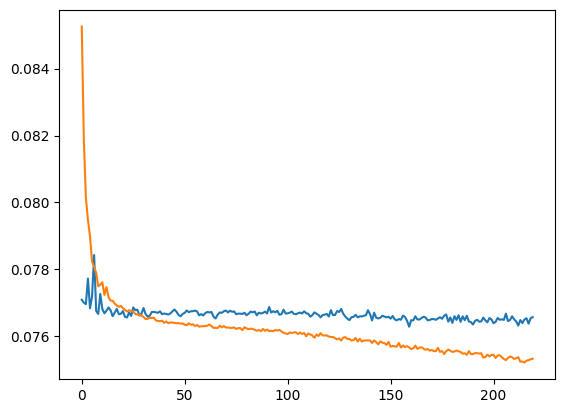

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['val_loss'][5:])
plt.plot(history.history['loss'][5:])

### lightgbm Model

In [27]:
import lightgbm as lgb
cf = lgb.LGBMRegressor(n_estimators=500)
cf.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

LGBMRegressor(n_estimators=500)

改天再研究
https://juejin.cn/post/7088258587138457637

```python
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(train,test,test_size=0.33,random_state=42)
```

In [28]:
#
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV

fit_params = {
    "early_stopping_rounds": 30,
    "eval_metric": 'auc',
    "eval_set":[test],  # 替換為測試數據集
    'eval_names': ['valid'],
    'verbose': 100,
    'categorical_feature': 'auto'
}

param_test = {
    'num_leaves': sp_randint(10, 100),
    'min_child_samples': sp_randint(50, 200),
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'subsample': sp_uniform(loc=0.1, scale=0.9),
    'colsample_bytree': sp_uniform(loc=0.2, scale=0.8),
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

# 調整為較小的值，例如100
n_HP_points_to_test = 100

# 將n_estimators設置為10000
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=10000)

gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test,
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True
)

In [29]:
# 替換為實際的訓練數據和適合的參數
gs.fit(*train, **fit_params)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid's auc: 0.555318
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid's auc: 0.555376
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid's auc: 0.546915
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.548168
Early stopping, best iteration is:
[154]	valid's auc: 0.551201
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[53]	valid's auc: 0.546735
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.542839
Early stopping, best iteration is:
[99]	valid's auc: 0.543529
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation

RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(metric='None', n_estimators=10000,
                                            n_jobs=4, random_state=314),
                   n_iter=100,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f22307a0e50>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f22307a0910>,
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0,
                                                             100.0, 1000.0,
                                                             10000.0],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f22307a0890>,
                                        'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10,
                    

In [30]:
best_params = gs.best_params_
print("Best Parameters:", best_params)
print("----------------")
gs_best_model = lgb.LGBMClassifier(**best_params )
gs_best_model.fit(*train)

Best Parameters: {'colsample_bytree': 0.849864595477118, 'min_child_samples': 97, 'min_child_weight': 0.01, 'num_leaves': 85, 'reg_alpha': 7, 'reg_lambda': 5, 'subsample': 0.1520960291082516}
----------------


LGBMClassifier(colsample_bytree=0.849864595477118, min_child_samples=97,
               min_child_weight=0.01, num_leaves=85, reg_alpha=7, reg_lambda=5,
               subsample=0.1520960291082516)

In [31]:
#

In [32]:
print('Training accuracy {:.4f}'.format(gs_best_model.score(*train)))
print('Testing accuracy {:.4f}'.format(gs_best_model.score(*test)))

Training accuracy 0.7280
Testing accuracy 0.5289


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

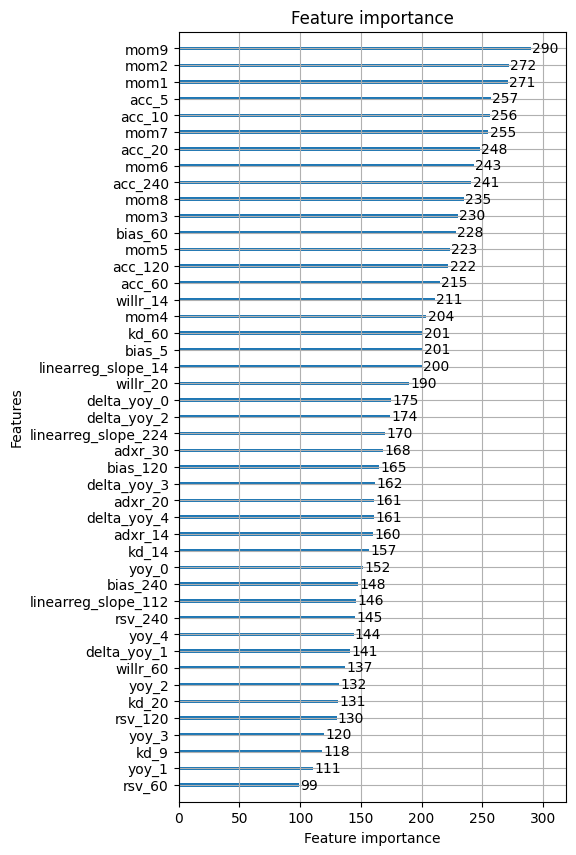

In [33]:
lgb.plot_importance(gs_best_model,figsize=(5,10))

In [34]:
#feature_imp = pd.DataFrame(zip(gs_best_model.feature_importances_, feature_names), 
#                           columns=['Value','Feature']).sort_values('Value', ascending=False)
#feature_imp
#
#%matplotlib inline
#import seaborn as sns
#plt.figure(figsize=(10,10))
#sns.barplot(x="Value", y="Feature", data=feature_imp)

### Random Forest Model

In [35]:
from sklearn.ensemble import RandomForestRegressor

cf2 = RandomForestRegressor(n_estimators=100)
cf2.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

RandomForestRegressor()

<AxesSubplot:xlabel='Value', ylabel='Feature'>

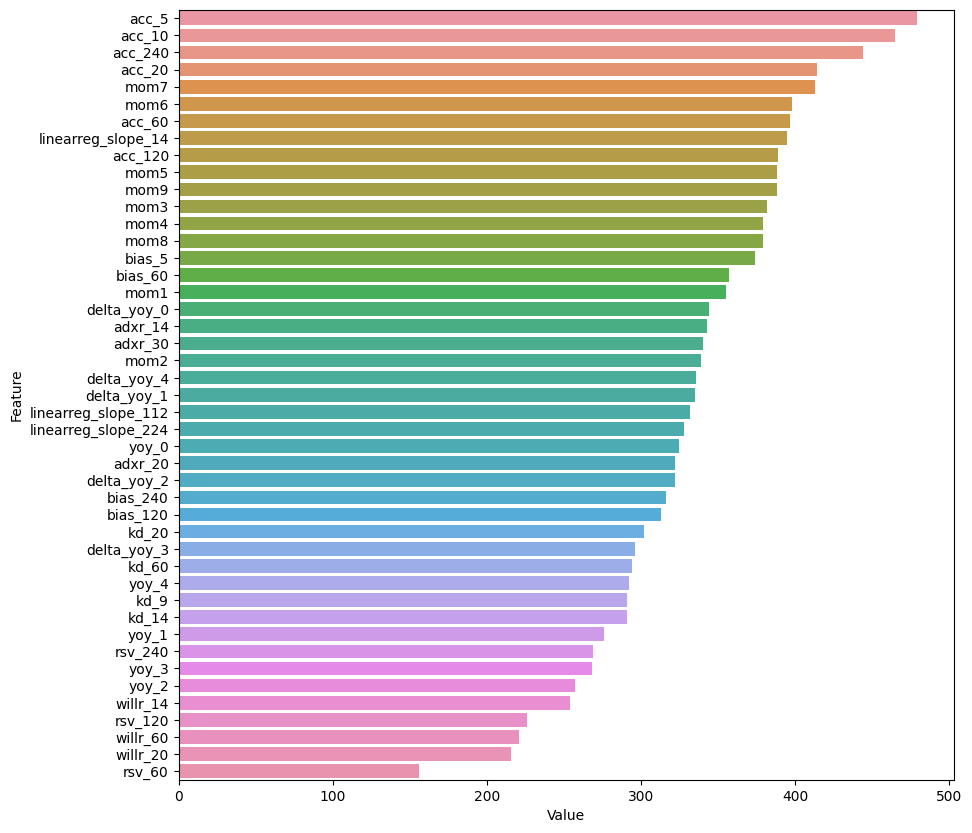

In [36]:
feature_imp = pd.DataFrame(zip(cf.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
plt.figure(figsize=(10,10))
sns.barplot(x="Value", y="Feature", data=feature_imp)

### Ensemble learning

In [37]:
dataset_drop = dataset.dropna(subset=feature_names+['return'])

vals = model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result1'] = pd.Series(vals.swapaxes(0,1)[0], dataset_drop.index)

vals = cf.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result2'] = pd.Series(vals, dataset_drop.index)

vals = cf2.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result3'] = pd.Series(vals, dataset_drop.index)

dataset_drop = dataset_drop.reset_index().set_index("date")

# backtest

100%|█████████████████████████████████████████| 169/169 [00:10<00:00, 15.67it/s]


<AxesSubplot:xlabel='date'>

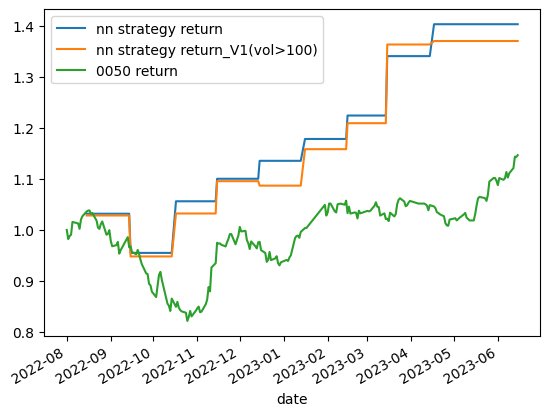

In [38]:
import math
from tqdm import tqdm

vol = 500
test_period = '2022-08'

dates = sorted(list(set(dataset_drop.index)))

rs = []
rs_v1 = []
rs_v2 = []
rs_v3 = []

for d in tqdm(dates):
    
    dataset_time = dataset_drop.loc[d]
    
    dataset_time = drop_extreme_case(dataset_time,
                                     feature_names, thresh=0.01)
    
    predi_target = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] 
    
    
    condition1 = dataset_time['vol_ma5'] > vol
    condition_Filter_v1 = condition1
    predi_target_v1 = predi_target * condition_Filter_v1.astype(float)
    
    condition2 = (1e10 < dataset_time['市值']) < 1e12  #(1e9 < dataset_time['市值']) < 1e10
    condition_Filter_v2 = condition2
    predi_target_v2 = predi_target * condition_Filter_v2.astype(float)
    
    condition_P = (predi_target >= predi_target.nlargest(20).iloc[-1])
    condition_v1 = (predi_target_v1 >= predi_target_v1.nlargest(20).iloc[-1])
    condition_v2 = (predi_target_v2 >= predi_target_v2.nlargest(20).iloc[-1])

    
    
    condition = (predi_target >= predi_target.nlargest(20).iloc[-1]) 
    r = dataset_time['return'][condition].mean()

    r = dataset_time['return'][condition_P].mean()
    rs.append(r * (1-3/1000-1.425/1000*2*0.6))
    
    r_v1 = dataset_time['return'][condition_v1].mean()
    rs_v1.append(r_v1 * (1-3/1000-1.425/1000*2*0.6))    
    
    r_v2 = dataset_time['return'][condition_v2].mean()
    rs_v2.append(r_v2 * (1-3/1000-1.425/1000*2*0.6))    

rs = pd.Series(rs, index=dates)[test_period:].cumprod()
rs_v1 = pd.Series(rs_v1, index=dates)[test_period:].cumprod() #*
rs_v2 = pd.Series(rs_v2, index=dates)[test_period:].cumprod() #*

s0050 = close['0050'][test_period:]

pd.DataFrame({'nn strategy return':rs.reindex(s0050.index, method='ffill'), 
              'nn strategy return_V1(vol>100)':rs_v1.reindex(s0050.index, method='ffill'),
              #'nn strategy return_V2(market cap)':rs_v2.reindex(s0050.index, method='ffill'),
              '0050 return':s0050/s0050[0]}).plot()



In [39]:
type(predi_target)

pandas.core.series.Series

In [40]:
dataset_time

,stock_id,mom1,mom2,mom3,mom4,mom5,mom6,mom7,mom8,mom9,...,adxr_14,adxr_20,adxr_30,vol_ma5,市值,return,rank,result1,result2,result3
date,,,,,,,,,,,,,,,,,,,,,
2023-04-15,1101,0.997385,0.582099,1.300745,0.851029,1.092571,0.973343,1.058143,1.104579,1.182602,...,34.334559,25.363687,32.093065,18564.7544,7.312830e+11,0.986825,0.635440,0.520921,0.573008,0.496366
2023-04-15,1102,1.296343,0.577242,1.004147,1.092745,1.086790,0.989370,0.898863,1.011343,0.972000,...,39.323125,22.324878,20.175022,4043.0210,4.769040e+11,1.011416,0.779345,0.520429,0.584323,0.565784
2023-04-15,1103,1.103720,0.836309,1.031029,1.058893,1.020291,1.125530,1.019829,0.976242,1.120205,...,48.138123,34.984146,33.740166,357.6222,2.725624e+10,0.984962,0.623025,0.485195,0.521867,0.491668
2023-04-15,1104,1.172781,0.695641,1.147553,0.995033,1.063337,0.986205,1.043231,1.012900,1.066928,...,44.756143,33.014225,31.199418,1602.2104,4.120310e+10,1.037037,0.854966,0.515946,0.503304,0.507260
2023-04-15,1108,1.226676,0.704955,1.090035,0.956558,1.157419,0.888687,1.193951,0.977786,1.005583,...,25.094527,47.419936,49.135414,4897.3474,1.046418e+10,0.952830,0.436230,0.531313,0.340653,0.489712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-15,9944,1.395066,0.783458,1.036210,1.095619,0.933960,1.040738,0.777281,0.951683,0.928396,...,16.093762,26.998820,24.263710,84.4532,3.764895e+09,1.066015,0.904063,0.492006,0.539852,0.489974
2023-04-15,9951,1.114727,0.727585,1.013367,1.155431,0.932085,0.990963,1.388135,0.907986,1.149515,...,26.587671,35.410072,35.405300,96.6176,1.165452e+10,0.965659,0.510722,0.521421,0.555098,0.580912
2023-04-15,9955,1.009254,0.991785,0.921606,1.131961,1.018326,0.967001,0.956274,1.060687,0.848890,...,61.287280,43.337794,33.125661,1694.0322,3.512948e+09,1.013436,0.787810,0.478552,0.536090,0.478594


In [41]:
predi_target

date
2023-04-15    1.590295
2023-04-15    1.670536
2023-04-15    1.498730
2023-04-15    1.526509
2023-04-15    1.361678
                ...   
2023-04-15    1.521832
2023-04-15    1.657430
2023-04-15    1.493235
2023-04-15    1.559418
2023-04-15    1.382829
Length: 1036, dtype: float64

### 當月持股狀況

In [42]:
# get the latest dataset
last_date = dataset.index.levels[1].max()#"2022-10-15"
is_last_date = dataset.index.get_level_values('date') == last_date
last_dataset = dataset[is_last_date].copy()


last_dataset = drop_extreme_case(last_dataset,
                                 feature_names, thresh=0.01)


# remove NaN testcases
last_dataset = last_dataset.dropna(subset=feature_names)

# predict

vals = model.predict(last_dataset[feature_names].astype(float))
last_dataset['result1'] = pd.Series(vals.swapaxes(0,1)[0], last_dataset.index)

vals = cf.predict(last_dataset[feature_names].astype(float))
last_dataset['result2'] = pd.Series(vals, last_dataset.index)

vals = cf2.predict(last_dataset[feature_names].astype(float))
last_dataset['result3'] = pd.Series(vals, last_dataset.index)

# calculate score

predi_target = last_dataset['result1'] + last_dataset['result2'] + last_dataset['result3']
condition = (predi_target >= rank.nlargest(20).iloc[-1]) 

# plot rank distribution
predi_target.hist(bins=20)


# show the best 20 stocks
slist1 = predi_target[condition].reset_index()['stock_id']

NameError: name 'rank' is not defined

# 平均分配資產於股票之中

In [ ]:
close = data.get("收盤價")

money = 1000000
stock_prices = close[predi_target[condition].reset_index()['stock_id']].iloc[-1]


print("股票平分張數:")
money / len(stock_prices) / stock_prices / 1000
